In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
# Load the predictions from our model
predictions = pd.read_csv("../outputs/lightgbm_daily_alpha_predictions.csv")
predictions['ts_utc'] = pd.to_datetime(predictions['ts_utc'])

print("🎯 Cross-Sectional Alpha Model Results")
print("=" * 50)
print(f"Test period: {predictions['ts_utc'].min().date()} to {predictions['ts_utc'].max().date()}")
print(f"Total observations: {len(predictions):,}")
print(f"Unique symbols: {predictions['symbol'].nunique()}")
print(f"Trading days: {predictions['ts_utc'].nunique()}")

# Recreate strategy performance
long_threshold = 0.8
short_threshold = 0.2

longs = predictions[predictions['rank_pct'] >= long_threshold]
shorts = predictions[predictions['rank_pct'] <= short_threshold]

print(f"\\nDaily positions:")
print(f"Long positions: {len(longs) / predictions['ts_utc'].nunique():.1f} avg per day")
print(f"Short positions: {len(shorts) / predictions['ts_utc'].nunique():.1f} avg per day")

# Calculate daily portfolio returns
daily_long = longs.groupby('ts_utc')['target'].mean()
daily_short = shorts.groupby('ts_utc')['target'].mean()
daily_ls = daily_long - daily_short

# Performance metrics
sharpe = daily_ls.mean() / daily_ls.std() * np.sqrt(252)
total_return = (1 + daily_ls).cumprod().iloc[-1] - 1
max_dd = ((1 + daily_ls).cumprod() / (1 + daily_ls).cumprod().expanding().max() - 1).min()
win_rate = (daily_ls > 0).mean()

print(f"\\n📊 Strategy Performance:")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Max Drawdown: {max_dd:.2%}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Daily Vol: {daily_ls.std() * np.sqrt(252):.2%}")

# Top performing symbols
print(f"\\n🔝 Most Frequent Long Positions:")
long_counts = longs['symbol'].value_counts().head()
for symbol, count in long_counts.items():
    pct = count / len(longs) * 100
    print(f"  {symbol}: {count} times ({pct:.1f}%)")

print(f"\\n🔻 Most Frequent Short Positions:")
short_counts = shorts['symbol'].value_counts().head()
for symbol, count in short_counts.items():
    pct = count / len(shorts) * 100
    print(f"  {symbol}: {count} times ({pct:.1f}%)")


🎯 Cross-Sectional Alpha Model Results
Test period: 2024-10-02 to 2025-03-27
Total observations: 10,189
Unique symbols: 87
Trading days: 126
\nDaily positions:
Long positions: 14.6 avg per day
Short positions: 13.3 avg per day
\n📊 Strategy Performance:
Sharpe Ratio: 1.37
Total Return: 17.00%
Max Drawdown: -18.36%
Win Rate: 50.00%
Daily Vol: 25.38%
\n🔝 Most Frequent Long Positions:
  QG: 48 times (2.6%)
  VIX: 47 times (2.6%)
  HH: 46 times (2.5%)
  NG: 46 times (2.5%)
  MBT: 43 times (2.3%)
\n🔻 Most Frequent Short Positions:
  HH: 71 times (4.3%)
  V2TX: 71 times (4.3%)
  QG: 70 times (4.2%)
  VIX: 65 times (3.9%)
  ETHUSDRR: 64 times (3.8%)


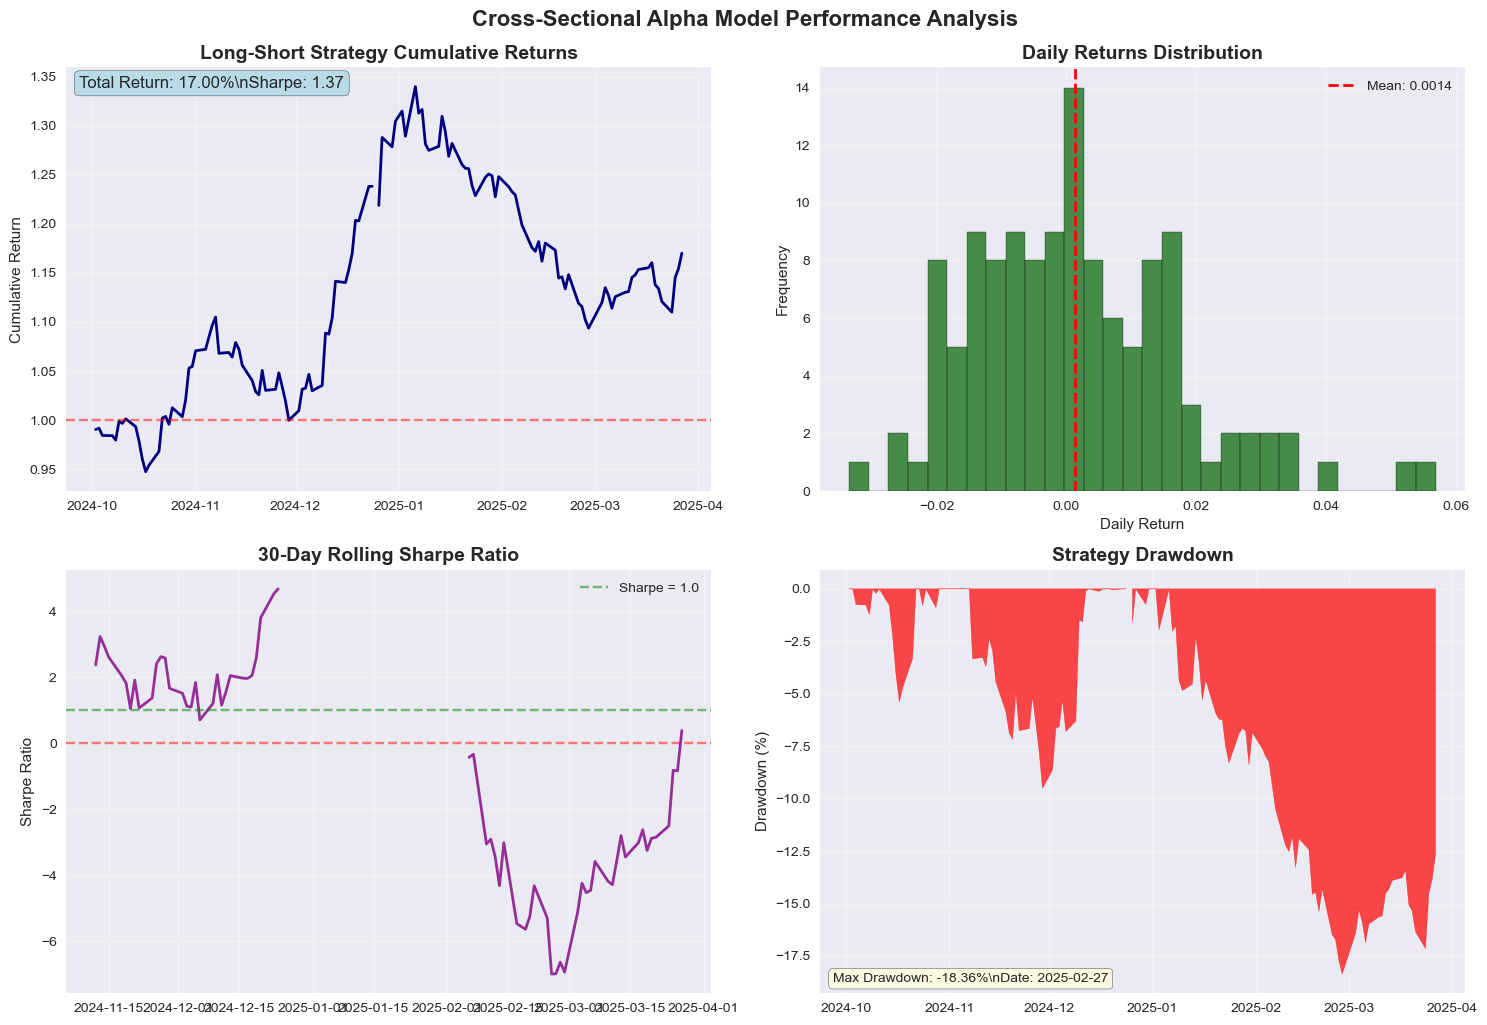

\n📅 Monthly Performance Summary:
ts_utc
2024-10-31     5.48%
2024-11-30    -5.20%
2024-12-31    30.46%
2025-01-31    -4.32%
2025-02-28   -11.84%
2025-03-31     6.35%
Freq: ME


In [3]:
# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cumulative Returns
cum_returns = (1 + daily_ls).cumprod()
axes[0,0].plot(cum_returns.index, cum_returns.values, linewidth=2, color='navy')
axes[0,0].set_title('Long-Short Strategy Cumulative Returns', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Cumulative Return')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(1, color='red', linestyle='--', alpha=0.5, label='Break-even')

# Add performance annotations
final_return = cum_returns.iloc[-1]
axes[0,0].text(0.02, 0.98, f'Total Return: {(final_return-1):.2%}\\nSharpe: {sharpe:.2f}', 
               transform=axes[0,0].transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# 2. Daily Returns Distribution
axes[0,1].hist(daily_ls, bins=30, alpha=0.7, color='darkgreen', edgecolor='black')
axes[0,1].axvline(daily_ls.mean(), color='red', linestyle='--', linewidth=2, 
                 label=f'Mean: {daily_ls.mean():.4f}')
axes[0,1].set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Daily Return')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio (30-day)
rolling_sharpe = daily_ls.rolling(30).mean() / daily_ls.rolling(30).std() * np.sqrt(252)
axes[1,0].plot(rolling_sharpe.index, rolling_sharpe.values, alpha=0.8, color='purple', linewidth=2)
axes[1,0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1,0].axhline(1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1.0')
axes[1,0].set_title('30-Day Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Sharpe Ratio')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Drawdown Analysis
running_max = cum_returns.expanding().max()
drawdown = (cum_returns / running_max - 1) * 100
axes[1,1].fill_between(drawdown.index, drawdown.values, 0, alpha=0.7, color='red')
axes[1,1].set_title('Strategy Drawdown', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Drawdown (%)')
axes[1,1].grid(True, alpha=0.3)

# Add max drawdown annotation
max_dd_pct = drawdown.min()
max_dd_date = drawdown.idxmin()
axes[1,1].text(0.02, 0.02, f'Max Drawdown: {max_dd_pct:.2f}%\\nDate: {max_dd_date.date()}',
               transform=axes[1,1].transAxes, fontsize=10, verticalalignment='bottom',
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.suptitle('Cross-Sectional Alpha Model Performance Analysis', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print monthly performance summary
monthly_returns = daily_ls.resample('M').apply(lambda x: (1 + x).prod() - 1)
print("\\n📅 Monthly Performance Summary:")
print(monthly_returns.to_string(float_format='{:.2%}'.format))
